## 主成分分析

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X    = iris.data
y    = iris.target

In [2]:
X.shape

(150, 4)

In [4]:
y.shape

(150,)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [6]:
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [9]:
X[0:3,:]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [10]:
X_reduced = pca.transform(X)

In [11]:
X_reduced[0:3,:]

array([[-2.68420713,  0.32660731],
       [-2.71539062, -0.16955685],
       [-2.88981954, -0.13734561]])

Populating the interactive namespace from numpy and matplotlib


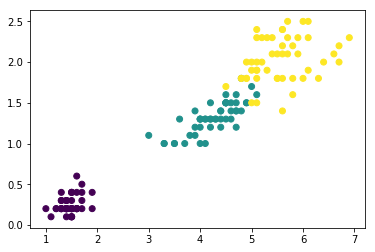

In [16]:
%pylab inline
from matplotlib import pyplot as plt
plt.scatter(X[:, 2], X[:, 3], c=y)
plt.show()

Populating the interactive namespace from numpy and matplotlib


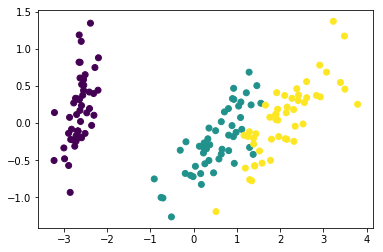

In [13]:
%pylab inline
from matplotlib import pyplot as plt
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)
plt.show()

In [14]:
pca.components_

array([[ 0.36158968, -0.08226889,  0.85657211,  0.35884393],
       [ 0.65653988,  0.72971237, -0.1757674 , -0.07470647]])

In [15]:
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component, iris.feature_names)))

0.362 x sepal length (cm) + -0.082 x sepal width (cm) + 0.857 x petal length (cm) + 0.359 x petal width (cm)
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.176 x petal length (cm) + -0.075 x petal width (cm)


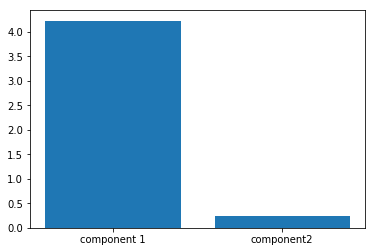

In [17]:
plt.bar(range(0,2), pca.explained_variance_)
plt.xticks(range(0,2), ['component 1', 'component2'])
plt.show()

In [18]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X_reduced, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

def plot_estimator(estimator, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.plot()
    plt.contourf(xx, yy, Z, alpha=0.4, cmap = plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y,  cmap = plt.cm.brg)
    plt.xlabel('Component1')
    plt.ylabel('Component2')
    plt.show()

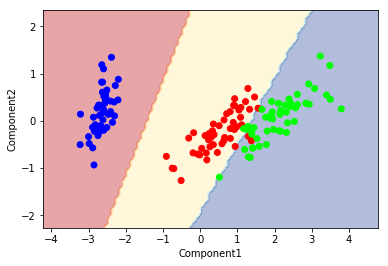

In [20]:

plot_estimator(clf, X_reduced, y)

In [23]:
predicted = clf.predict(X_reduced)

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y, predicted)

0.9666666666666667

In [26]:
confusion_matrix(y, predicted)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  2, 48]], dtype=int64)

## 利用自編碼網路重建影像

In [35]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [36]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [37]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [38]:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [39]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### 讀取MNIST數據

In [40]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [44]:
x_train= x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255.
x_train= x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### 訓練模型

In [47]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1037 - val_loss: 0.1019
Epoch 2/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1034 - val_loss: 0.1016
Epoch 3/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1031 - val_loss: 0.1013
Epoch 4/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1028 - val_loss: 0.1011
Epoch 5/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.1026 - val_loss: 0.1008
Epoch 6/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1023 - val_loss: 0.1006
Epoch 7/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.1021 - val_loss: 0.1004
Epoch 8/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.1019 - val_loss: 0.1002
Epoch 9/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1017 - val_loss: 0.1000
Epoch

### 檢視編碼與重建數據 

In [48]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
encoded_imgs.shape

(10000, 32)

In [49]:
1 / 24.5

0.04081632653061224

In [50]:
decoded_imgs = decoder.predict(encoded_imgs)

In [52]:
decoded_imgs.shape

(10000, 784)

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


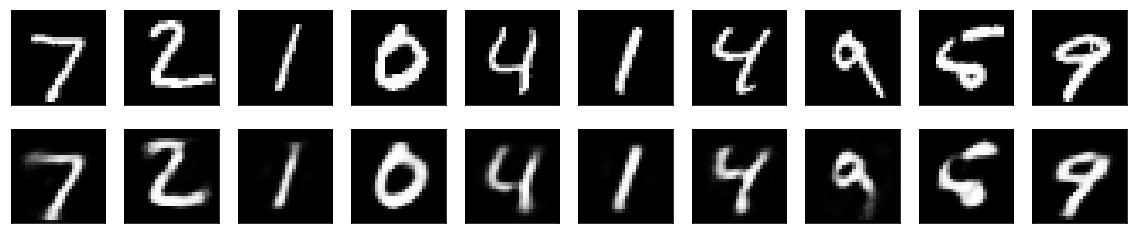

In [54]:
%pylab inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 疑問解答

In [68]:
from keras.datasets import mnist
import numpy as np
(x_train2, _), (x_test2, _) = mnist.load_data()

In [69]:
x_train2.shape

(60000, 28, 28)

In [70]:
x_test2.shape

(10000, 28, 28)

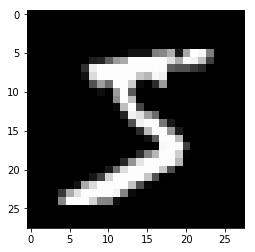

In [71]:
plt.imshow(x_train2[0])

In [72]:
x_train2 = x_train2.reshape(60000,784)
x_train2.shape

(60000, 784)

In [60]:
y    = iris.target
y.shape

(150,)

In [62]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [64]:
y2 = y.reshape(150,1)
y2.shape

(150, 1)

In [74]:
#print(y2)

In [77]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#sc.fit_transform(iris.target)
#sc.fit_transform(iris.target.reshape(150,1))

## 信用卡詐欺預測
- https://www.kaggle.com/mlg-ulb/creditcardfraud

### 引用套件

In [78]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%pylab inline

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Populating the interactive namespace from numpy and matplotlib


### 讀取資料

In [79]:
df = pd.read_csv("creditcard.csv")

In [81]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 資料探索 (Exploratory Data Analysis)

In [82]:
count_classes = pd.value_counts(df['Class'], sort = True)

In [84]:
count_classes

0    284315
1       492
Name: Class, dtype: int64

Text(0,0.5,'Frequency')

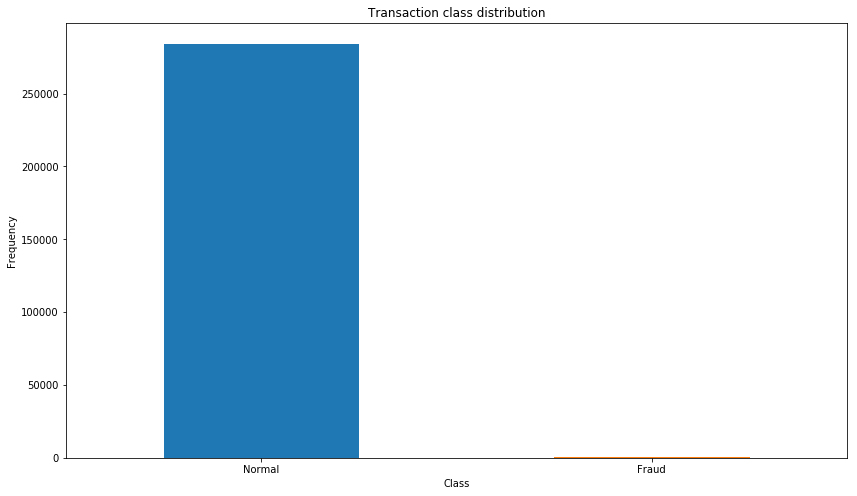

In [85]:
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

### 檢視轉帳金額

In [86]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

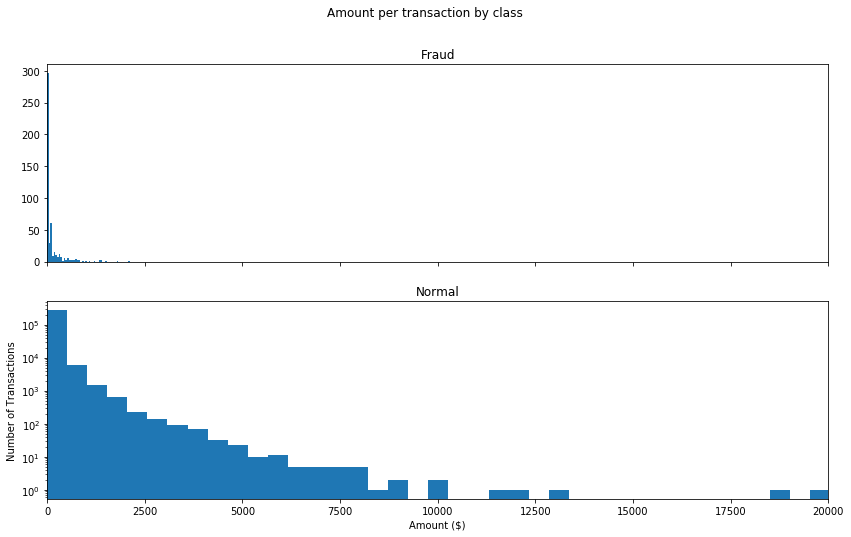

In [87]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

### 檢視是否轉帳時間很重要

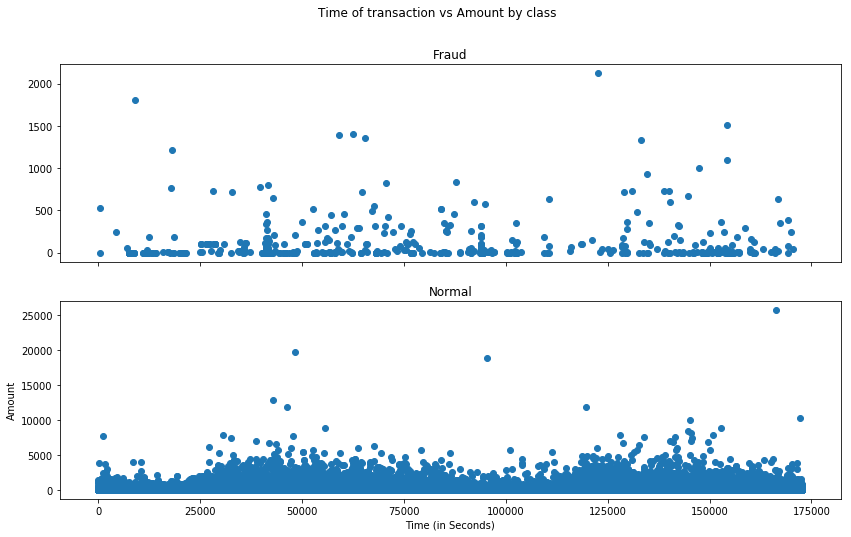

In [88]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

### 標準化資料

In [89]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

sc = StandardScaler()
data['Amount'] = sc.fit_transform(data['Amount'].values.reshape(-1, 1))

In [137]:
data['Amount'].values.shape

(284807,)

In [142]:
data['Amount'].values.reshape(-1, 1).shape
data['Amount'].values.reshape(284807, 1).shape

(284807, 1)

In [91]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


### 將資料分為訓練與測試資料集

In [92]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [95]:
#X_train[0:3,:]

### 建立 Auto Encoders

In [102]:

input_dim = X_train.shape[1]
encoding_dim = 14

In [103]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(7, activation="relu")(encoder)

decoder = Dense(7, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [104]:
nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/10
227451/227451 [==============================] - 6s 25us/step - loss: 0.8096 - acc: 0.6079 - val_loss: 0.7827 - val_acc: 0.6848
Epoch 2/10
227451/227451 [==============================] - 6s 24us/step - loss: 0.7426 - acc: 0.6828 - val_loss: 0.7689 - val_acc: 0.6879
Epoch 3/10
227451/227451 [==============================] - 5s 24us/step - loss: 0.7342 - acc: 0.6874 - val_loss: 0.7630 - val_acc: 0.6893
Epoch 4/10
227451/227451 [==============================] - 5s 24us/step - loss: 0.7306 - acc: 0.6897 - val_loss: 0.7604 - val_acc: 0.6973
Epoch 5/10
227451/227451 [==============================] - 5s 23us/step - loss: 0.7285 - acc: 0.6923 - val_loss: 0.7728 - val_acc: 0.6755
Epoch 6/10
227451/227451 [==============================] - 5s 22us/step - loss: 0.7268 - acc: 0.6940 - val_loss: 0.7588 - val_acc: 0.6899
Epoch 7/10
227451/227451 [==============================] - 5s 22us/step - loss: 0.7258 - acc: 0.6962 - val_loss: 0

### 模型評估

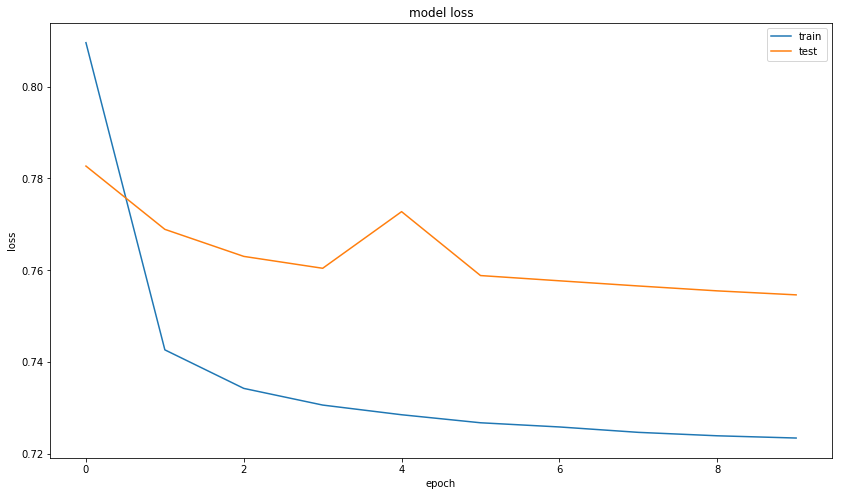

In [105]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [106]:
predictions = autoencoder.predict(X_test)

In [108]:
X_test.shape

(56962, 29)

In [109]:
predictions.shape

(56962, 29)

In [112]:
a = np.array([3,5,4])
b = np.array([2,6,4])
sum((a - b) ** 2)

2

In [113]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [114]:
error_df

,reconstruction_error,true_class
43428,82.235584,1
49906,0.831832,0
29474,0.255133,0
276481,0.431859,0
278846,0.181755,0
101565,0.950683,0
260880,0.185870,0
214337,0.412748,0
201575,0.607719,0
81055,2.911944,0


In [115]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

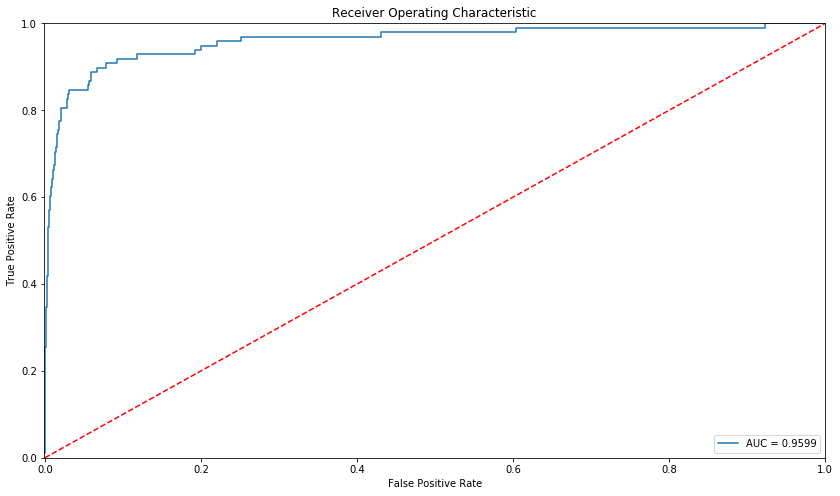

In [116]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 找尋最佳切點

In [118]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame(
    {'fpr'   : pd.Series(fpr, index=i),
     'tpr'   : pd.Series(tpr, index = i), 
     '1-fpr' : pd.Series(1-fpr, index = i), 
     'tf'    : pd.Series(tpr - (1-fpr), index = i), 
     'thresholds' : pd.Series(thresholds, index = i)})


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,fpr,tpr,1-fpr,tf,thresholds
166,0.092994,0.908163,0.907006,0.001157,1.031592


In [121]:
roc.head()

,fpr,tpr,1-fpr,tf,thresholds
0,0.000000,0.010204,1.000000,-0.989796,269.754253
1,0.000000,0.030612,1.000000,-0.969388,161.475842
2,0.000106,0.030612,0.999894,-0.969282,136.937437
3,0.000106,0.040816,0.999894,-0.959078,119.181768
4,0.000123,0.040816,0.999877,-0.959061,118.327203


In [125]:
a = np.array([30,20,50,40,80])
a.argsort()

array([1, 0, 3, 2, 4], dtype=int64)

166

In [127]:
roc.ix[(roc.tf-0).abs().argsort()[0]]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


fpr           0.092994
tpr           0.908163
1-fpr         0.907006
tf            0.001157
thresholds    1.031592
Name: 166, dtype: float64

In [132]:
roc['tf2'] = roc['tf'].abs()

In [136]:
roc.sort_values('tf2').head(3)

,fpr,tpr,1-fpr,tf,thresholds,tf2
166,0.092994,0.908163,0.907006,0.001157,1.031592,0.001157
165,0.088369,0.908163,0.911631,-0.003468,1.058347,0.003468
164,0.088316,0.908163,0.911684,-0.003521,1.058529,0.003521


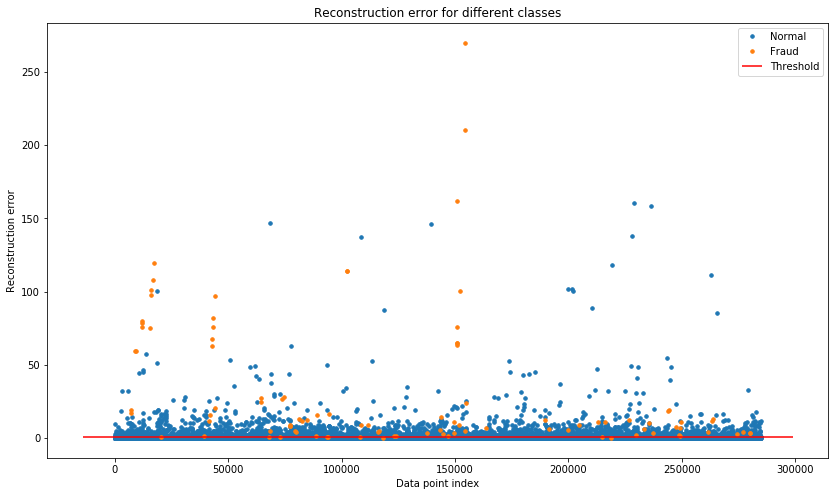

In [129]:
threshold = 1.031592
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [130]:

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
conf_matrix

array([[51577,  5287],
       [    9,    89]], dtype=int64)

## 訓練 GAN

### 設定網路參數

In [143]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

### 建立鑑別器

In [151]:
def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

### 建立生成器

In [152]:
def build_generator():

    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

### 編譯鑑別器

In [153]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


### 編譯生成器

In [154]:
# Build the generator
generator = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_19 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              525312    
__________

In [155]:
# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


### 訓練GAN

In [156]:
def train(epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake  = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)


### 圖片取樣

In [157]:
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

In [158]:
import os
if not os.path.exists('images'):
    os.mkdir('images')

In [ ]:
train(1000, batch_size=128, sample_interval=50)

## Leaky ReLU

In [144]:
def relu_function(x):
    return np.maximum(0,x)

x = np.array([-1,1,2])
relu_function(x)

array([0, 1, 2])

In [146]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-5,5,200)

len(z)

Populating the interactive namespace from numpy and matplotlib


200

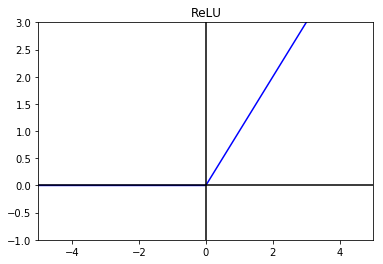

In [147]:
plt.plot(z, relu_function(z), "b")
plt.plot([-5, 5], [0, 0], 'k')
plt.plot([0, 0], [-1, 3], 'k')
plt.title("ReLU")
plt.axis([-5, 5, -1, 3])
plt.show()

In [148]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

x = np.array([-1,1,2])
leaky_relu(x)


array([-0.01,  1.  ,  2.  ])

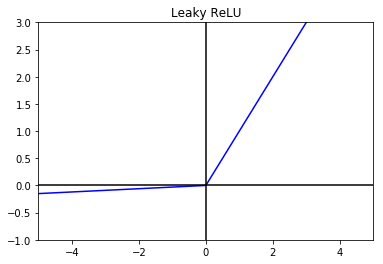

In [150]:
plt.plot(z, leaky_relu(z, 0.03), "b")
plt.plot([-5, 5], [0, 0], 'k')
plt.plot([0, 0], [-1, 3], 'k')
plt.title("Leaky ReLU")
plt.axis([-5, 5, -1, 3])
plt.show()

## DCGAN

### 設定參數

In [165]:
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.layers import Flatten, BatchNormalization, Dense, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

### 讀取圖片數據

In [166]:
def load_dataset(dataset_path, batch_size, image_shape):
    dataset_generator = ImageDataGenerator()
    dataset_generator = dataset_generator.flow_from_directory(
        dataset_path, target_size=(image_shape[0], image_shape[1]),
        batch_size=batch_size,
        class_mode=None)

    return dataset_generator

### 建立生成器

In [167]:
def build_generator():

    model = Sequential()

    model.add(Dense(units=4 * 4 * 512,
                   input_shape=(1, 1, 100)))
    model.add(Reshape(target_shape=(4, 4, 512)))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(Activation('tanh'))
    model.summary()
    optimizer = Adam(lr=0.00015, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=None)

    return model

### 建立鑑別器

In [170]:
def build_discriminator():

    model = Sequential()
    
    image_shape = (64, 64, 3)
    model.add(Conv2D(filters=64, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             input_shape=(image_shape)))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=128, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=256, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=512, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()

    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

    return model

### 圖片取樣

In [171]:
def sample_images(generated_images, epoch):

    plt.figure(figsize=(8, 8), num=2)
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0, hspace=0)

    for i in range(generated_images.shape[0]):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = generated_images[i, :, :, :]
        image += 1
        image *= 127.5
        fig = plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    save_name = 'images/generatedSamples_epoch' + str(
        epoch + 1) + '.png'

    plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
    plt.pause(0.0000000001)
    plt.show()

### 建立生成器

In [172]:
generator = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 1, 1, 8192)        827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 256)         0         
__________

### 建立鉴别器

In [173]:
discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 256)         1024      
__________

### 讀取明星圖片

In [174]:
dataset_path = 'train/'
batch_size   =  64
image_shape  = (64, 64, 3)

dataset_generator = load_dataset(dataset_path, batch_size, image_shape)

Found 355 images belonging to 3 classes.


In [175]:

number_of_batches  = int(dataset_generator.samples / batch_size)
adversarial_loss   = np.empty(shape=1)
discriminator_loss = np.empty(shape=1)
epochs = 250

In [176]:
gan = Sequential()

discriminator.trainable = False
gan.add(generator)
gan.add(discriminator)

optimizer = Adam(lr=0.00015, beta_1=0.5)
gan.compile(loss='binary_crossentropy', optimizer=optimizer,
                    metrics=None)

In [177]:
import os
if not os.path.exists('models'):
    os.mkdir('models')

Epoch 1 / 250:
 generator loss 4.880463600158691 | discriminator loss 5.302628517150879 
 generator loss 5.1519012451171875 | discriminator loss 1.6900653839111328 
 generator loss 12.263141632080078 | discriminator loss 2.5148611068725586 
 generator loss 12.641436576843262 | discriminator loss 2.3188419342041016 
 generator loss 5.418460845947266 | discriminator loss 2.018657684326172 
Epoch 2 / 250:
 generator loss 7.719144821166992 | discriminator loss 1.577185869216919 
 generator loss 2.3154304027557373 | discriminator loss 1.938058853149414 
 generator loss 14.449848175048828 | discriminator loss 5.573801040649414 
 generator loss 14.570398330688477 | discriminator loss 2.7100837230682373 
 generator loss 14.574824333190918 | discriminator loss 2.449284791946411 
Epoch 3 / 250:
 generator loss 14.577336311340332 | discriminator loss 2.892026424407959 
 generator loss 14.412961959838867 | discriminator loss 2.4225847721099854 
 generator loss 14.528674125671387 | discriminator lo

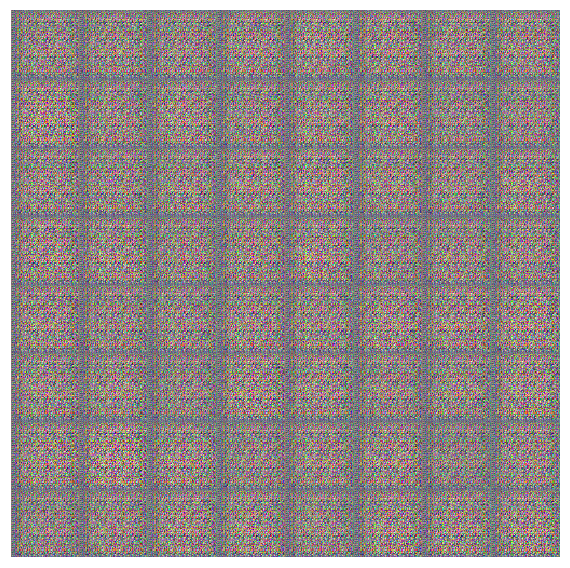

Epoch 6 / 250:
 generator loss 14.50556468963623 | discriminator loss 2.1074161529541016 


In [ ]:
for epoch in range(epochs):
    print("Epoch {} / {}:".format(epoch+1, epochs))

    for batch_number in range(number_of_batches):
        # 取得一批图片数据
        real_images = dataset_generator.next()
        # 将图片标准化至-1到1
        real_images = real_images / 127.5 - 1.

        # 每批大小不同，需每次计算该批数据量
        current_batch_size = real_images.shape[0]

        # 产生噪音
        noise = np.random.normal(0, 1, size=(current_batch_size,) + (1, 1, 100))

        # 使用生成器生成图片
        generated_images = generator.predict(noise)

        # 增加噪音扰乱鉴别器
        real_y = (np.ones(current_batch_size) - np.random.random_sample(current_batch_size) * 0.2)
        fake_y = np.random.random_sample(current_batch_size) * 0.2

        # 训练鉴别器
        discriminator.trainable = True

        d_loss = discriminator.train_on_batch(real_images, real_y)
        d_loss += discriminator.train_on_batch(generated_images, fake_y)

        discriminator_loss = np.append(discriminator_loss, d_loss)

        # 训练生成器
        discriminator.trainable = False

        noise = np.random.normal(0, 1,size=(current_batch_size * 2,) +(1, 1, 100))

        # 给予反向标签以误导鉴别器
        fake_y = (np.ones(current_batch_size * 2) -
                      np.random.random_sample(current_batch_size * 2) * 0.2)

        g_loss = gan.train_on_batch(noise, fake_y)
        adversarial_loss = np.append(adversarial_loss, g_loss)
    

        # 打印损失
        print(" generator loss {} | discriminator loss {} ".format(g_loss, d_loss))


    # 存储模型与生成图片
    if (epoch + 1) % 5 == 0:
        discriminator.trainable = True
        generator.save('models/generator_epoch' + str(epoch) + '.hdf5')
        discriminator.save('models/discriminator_epoch' +str(epoch) + '.hdf5')
        
        sample_images(generated_images, epoch)